In [20]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier

In [21]:
df = pd.read_csv('IMDb movies.csv')
df = df[~df['language'].str.split().str[0].eq("None")]
df = df.drop(['imdb_title_id', 'title', 'original_title', 'date_published', 
         'description', 'usa_gross_income',  'reviews_from_users', 
         'reviews_from_critics', 'avg_vote', 'votes', 'metascore', 'writer'], axis=1)
df = df.reset_index(drop=True)
df['profit'] = df['worlwide_gross_income'].str.split().str[-1].astype(float) - df['budget'].str.split().str[-1].astype(float)
df = df.dropna()
df = df.reset_index(drop=True)
df_y = pd.Series([1 if i > 0 else 0 for i in df.profit], name='rating')
# df.metascore = df.metascore.astype(int)
df = df.drop(['worlwide_gross_income', 'budget', 'profit'], axis=1)
print('Feature names:\n' + ', '.join(list(df)))
print(len(df))

Feature names:
year, genre, duration, country, language, director, production_company, actors
9079


In [22]:
df

,year,genre,duration,country,language,director,production_company,actors
0,1920,"Fantasy, Horror, Mystery",76,Germany,German,Robert Wiene,Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ..."
1,1921,"Comedy, Drama, Family",68,USA,English,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch..."
2,1923,"Drama, Romance",82,USA,English,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,..."
3,1925,"Adventure, Comedy, Drama",95,USA,English,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry..."
4,1927,"Crime, Drama, Mystery",68,UK,English,Alfred Hitchcock,Gainsborough Pictures,"Marie Ault, Arthur Chesney, June Tripp, Malcol..."
...,...,...,...,...,...,...,...,...
9074,2011,Drama,109,Italy,Italian,Daniele Gaglianone,Zaroff Film,"Filippo Timi, Stefano Accorsi, Valerio Mastand..."
9075,2010,Action,117,Thailand,Thai,Nirattisai Kaljareuk,Kantana Laboratories Co.,"Ad Carabao, Sara Legge, Arnut Rapanit, Lalisa ..."
9076,2012,"Drama, Sci-Fi, Thriller",101,"Germany, USA",English,Eron Sheean,Instinctive Film,"Michael Eklund, Karoline Herfurth, Tómas Lemar..."
9077,2012,Drama,98,Germany,German,Nina Grosse,UFA Fiction,"Katja Riemann, Sebastian Koch, Sylvester Groth..."


In [23]:
df_y.value_counts(normalize = True)

0    0.553916
1    0.446084
Name: rating, dtype: float64

In [24]:
text_features = ['genre', 'country', 'language', 'director', 'production_company', 'actors']
cat_features = ['year', 'duration']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df_y, test_size=0.33, random_state=4)

In [29]:
def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )
    
    catboost_default_params = {
        'leaf_estimation_method': 'Gradient',
        'learning_rate': 0.01,
        'depth': 8,
        'bootstrap_type': 'Bernoulli',
        'objective': 'CrossEntropy',
        'subsample': 0.8,
        'random_state': 42,
        "eval_metric" : 'TotalF1',
        "early_stopping_rounds" : 100
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

In [30]:
model = fit_catboost(X_train, X_test, y_train, y_test)

/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py:1325: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


0:	learn: 0.6378334	test: 0.5900208	best: 0.5900208 (0)	total: 652ms	remaining: 10m 51s
100:	learn: 0.6639466	test: 0.6330094	best: 0.6338118 (94)	total: 59.7s	remaining: 8m 51s
200:	learn: 0.6769266	test: 0.6478075	best: 0.6478075 (200)	total: 2m 5s	remaining: 8m 19s
300:	learn: 0.6961507	test: 0.6609310	best: 0.6616153 (298)	total: 3m 12s	remaining: 7m 26s
400:	learn: 0.7087792	test: 0.6650270	best: 0.6650270 (393)	total: 4m 11s	remaining: 6m 16s
500:	learn: 0.7173962	test: 0.6672895	best: 0.6679713 (480)	total: 5m 11s	remaining: 5m 10s
600:	learn: 0.7278259	test: 0.6729205	best: 0.6741093 (589)	total: 6m 3s	remaining: 4m 1s
700:	learn: 0.7370194	test: 0.6794397	best: 0.6795040 (693)	total: 7m	remaining: 2m 59s
800:	learn: 0.7436135	test: 0.6820307	best: 0.6833265 (789)	total: 7m 55s	remaining: 1m 58s
900:	learn: 0.7504001	test: 0.6848787	best: 0.6848787 (900)	total: 8m 49s	remaining: 58.2s
999:	learn: 0.7610165	test: 0.6878436	best: 0.6885237 (992)	total: 9m 50s	remaining: 0us

best

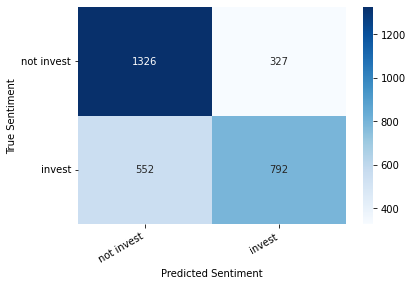

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['not invest', 'invest']

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

cm = confusion_matrix(y_test, model.predict(X_test))
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)